In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Processing

Before being able to apply the synthetic interventions method, we need to pre-process the data a bit.

First, let's load the data and take a look at it. This data comes from Johns Hopkins (https://github.com/CSSEGISandData/COVID-19), which provides information on cumulative COVID-19 related deaths. We have preprocessed the data to show daily values.

In [6]:
covid_df = pd.read_csv("data_global_data.csv")
covid_df.loc[202045:202050] ## The indices here are just hardcoded to find the United States entries

,country,date,deaths,daily_deaths
202045,US,03/12/20,43,10.0
202046,US,03/13/20,51,8.0
202047,US,03/14/20,58,7.0
202048,US,03/15/20,70,12.0
202049,US,03/16/20,97,27.0
202050,US,03/17/20,134,37.0


Before being able to work with the data, there's two preprocessing steps that will be helpful: (a) converting the dates into a datetime object in Pandas, and (b) renaming "US" in the country column to "United States"

In [7]:
covid_df = covid_df.applymap(lambda x: "United States" if x == 'US' else x)
covid_df['date'] = pd.to_datetime(covid_df['date'])
covid_df.loc[202045:202050]

C:\Users\adevr\AppData\Local\Temp\ipykernel_14740\2300812426.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  covid_df = covid_df.applymap(lambda x: "United States" if x == 'US' else x)
C:\Users\adevr\AppData\Local\Temp\ipykernel_14740\2300812426.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  covid_df['date'] = pd.to_datetime(covid_df['date'])


,country,date,deaths,daily_deaths
202045,United States,2020-03-12,43,10.0
202046,United States,2020-03-13,51,8.0
202047,United States,2020-03-14,58,7.0
202048,United States,2020-03-15,70,12.0
202049,United States,2020-03-16,97,27.0
202050,United States,2020-03-17,134,37.0


## Outline
We'll process this data in three steps:

1. Define time steps for the pre-intervention and post-intervention period
2. Assign mobility interventions
3. Reshape the data into a matrix form


## Defining Time Steps

First, we establish the time stamps of the data relative to the point at which 80 cumulative deaths are observed for each country. That is, the timestamp for the first date after which there are 80 cumulative deaths is 0. This let's us use timestamps -20 to -1 as a "pre-intervention" period and timestamps 0 to 20 as a "post-intervention" period.

In [8]:
pre_intervention_death_count = 80

covid_df['post-intervention'] = covid_df['deaths'] >= pre_intervention_death_count
covid_df.head()

,country,date,deaths,daily_deaths,post-intervention
0,Afghanistan,2020-01-23,0,0.0,False
1,Afghanistan,2020-01-24,0,0.0,False
2,Afghanistan,2020-01-25,0,0.0,False
3,Afghanistan,2020-01-26,0,0.0,False
4,Afghanistan,2020-01-27,0,0.0,False


In [9]:
# get post-intervention date for each country
t0_date = covid_df[covid_df['post-intervention']].groupby('country')['date'].min()
t0_date

country
Afghanistan          2020-05-06
Albania              2020-07-07
Algeria              2020-04-02
Andorra              2020-12-18
Angola               2020-08-11
                        ...    
Vietnam              2021-06-29
West Bank and Gaza   2020-07-29
Yemen                2020-05-31
Zambia               2020-07-17
Zimbabwe             2020-08-03
Name: date, Length: 179, dtype: datetime64[ns]

In [10]:
# get timestamps -- first, create a column with the t0 date for each country through a merge
covid_df = pd.merge(covid_df, t0_date.reset_index(), on='country', how='left')\
                .rename(columns={'date_x': 'date', 'date_y': 't0_date'})

# next, extract the difference between the date of the current observation and the t = 0 date
covid_df['t'] = (covid_df['date'] - covid_df['t0_date']).dt.days

In [11]:
# we only need the dates on where t is between -20 and 20
covid_df = covid_df[(covid_df['t'] >= -20) & (covid_df['t'] <= 20)]

In [12]:
# now, we see that each country has a time index which is an integer between -20 and 20
covid_df.head()

,country,date,deaths,daily_deaths,post-intervention,t0_date,t
84,Afghanistan,2020-04-16,29,4.0,False,2020-05-06,-20.0
85,Afghanistan,2020-04-17,30,1.0,False,2020-05-06,-19.0
86,Afghanistan,2020-04-18,30,0.0,False,2020-05-06,-18.0
87,Afghanistan,2020-04-19,30,0.0,False,2020-05-06,-17.0
88,Afghanistan,2020-04-20,33,3.0,False,2020-05-06,-16.0


## Assigning Mobility Interventions

Next, we want to assign __interventions__ for each country. We will do this using Google mobility data (https://www.google.com/covid19/mobility/). The Google data is reported relative to pre-2020 mobility, such that a score of -10 means that on that date, the mobility of a country's population is 10% less than pre-2020 levels. We will bucket countries as having three possible interventions:

| Intervention Type     | Reduction in Mobility (Compared to Jan. 2020 Baseline) |
|:----       |    :----:   | 
| Low    | <10%       |
| Moderate   | 10-40%        |
| Severe  | >40%        |

    
We'll measure the mobility reduction in the time period between $t = -20$ to $t = -1$, as we anticipate a delay between mobility reductions and reported case counts. That is, we're going to make an assumption that it takes about 20 days for a reduction in mobility to impact future case counts.

In [13]:
mobility_df = pd.read_csv('data/Global_Mobility_Report.csv').rename(columns={'country_region': 'country'})
# restrict only to country wide data
mobility_df = mobility_df[mobility_df['sub_region_1'].isnull() & \
                          mobility_df['sub_region_2'].isnull() & \
                          mobility_df['metro_area'].isnull()]

mobility_df['date'] = pd.to_datetime(mobility_df['date'])
mobility_df[['country', 'date', 'retail_and_recreation_percent_change_from_baseline']].loc[184050:184055]

FileNotFoundError: [Errno 2] No such file or directory: 'data/Global_Mobility_Report.csv'

In [ ]:
mobility_df

,country_region_code,country,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193760,ZW,Zimbabwe,NaN,NaN,NaN,NaN,NaN,ChIJYXGxBuekMRkR7r_LxV84wKE,2022-10-11,122.0,132.0,244.0,142.0,101.0,13.0
193761,ZW,Zimbabwe,NaN,NaN,NaN,NaN,NaN,ChIJYXGxBuekMRkR7r_LxV84wKE,2022-10-12,123.0,132.0,247.0,148.0,100.0,13.0
193762,ZW,Zimbabwe,NaN,NaN,NaN,NaN,NaN,ChIJYXGxBuekMRkR7r_LxV84wKE,2022-10-13,130.0,134.0,247.0,149.0,94.0,13.0
193763,ZW,Zimbabwe,NaN,NaN,NaN,NaN,NaN,ChIJYXGxBuekMRkR7r_LxV84wKE,2022-10-14,132.0,140.0,239.0,149.0,100.0,11.0


In [ ]:
covid_df

,country,date,deaths,daily_deaths,post-intervention,t0_date,t
84,Afghanistan,2020-04-16,29,4.0,False,2020-05-06,-20.0
85,Afghanistan,2020-04-17,30,1.0,False,2020-05-06,-19.0
86,Afghanistan,2020-04-18,30,0.0,False,2020-05-06,-18.0
87,Afghanistan,2020-04-19,30,0.0,False,2020-05-06,-17.0
88,Afghanistan,2020-04-20,33,3.0,False,2020-05-06,-16.0
...,...,...,...,...,...,...,...
217409,Zimbabwe,2020-08-19,150,9.0,True,2020-08-03,16.0
217410,Zimbabwe,2020-08-20,151,1.0,True,2020-08-03,17.0
217411,Zimbabwe,2020-08-21,152,1.0,True,2020-08-03,18.0
217412,Zimbabwe,2020-08-22,153,1.0,True,2020-08-03,19.0


In [ ]:
# get mobility scores specifically on the dates that are reported in the covid_df when t is between -20 and -1
mobility_df = pd.merge(mobility_df, covid_df[covid_df['t'] < 0], on=['country', 'date'], how='right')

# we can see that the retail scores are now only on the dates we care about for each country
mobility_df[['country', 'date', 't', 'retail_and_recreation_percent_change_from_baseline']].head()

,country,date,t,retail_and_recreation_percent_change_from_baseline
0,Afghanistan,2020-04-16,-20.0,-46.0
1,Afghanistan,2020-04-17,-19.0,-41.0
2,Afghanistan,2020-04-18,-18.0,-43.0
3,Afghanistan,2020-04-19,-17.0,-43.0
4,Afghanistan,2020-04-20,-16.0,-42.0


In [ ]:
# now we group countries based on their scores
country_mobility_scores = \
        mobility_df.groupby('country')['retail_and_recreation_percent_change_from_baseline'].mean()

low_countries = []
moderate_countries = []
severe_countries = []

for country, score in country_mobility_scores.items():
    if(not pd.isnull(score)):
        if(score > -10):
            low_countries.append(country)
        elif(score < -40):
            severe_countries.append(country)
        else:
            moderate_countries.append(country)

In [ ]:
len(low_countries), len(moderate_countries), len(severe_countries)

(23, 50, 50)

## Reshaping the Data

Our last step is just to get the dataset into a nice matrix format for running synthetic interventions

In [ ]:
covid_df.head()

,country,date,deaths,daily_deaths,post-intervention,t0_date,t
84,Afghanistan,2020-04-16,29,4.0,False,2020-05-06,-20.0
85,Afghanistan,2020-04-17,30,1.0,False,2020-05-06,-19.0
86,Afghanistan,2020-04-18,30,0.0,False,2020-05-06,-18.0
87,Afghanistan,2020-04-19,30,0.0,False,2020-05-06,-17.0
88,Afghanistan,2020-04-20,33,3.0,False,2020-05-06,-16.0


In [ ]:
covid_df = covid_df[['country', 'daily_deaths', 't']]\
        .pivot(index='country', columns='t', values='daily_deaths').reset_index()

covid_df.head()

t,country,-20.0,-19.0,-18.0,-17.0,-16.0,-15.0,-14.0,-13.0,-12.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0
0,Afghanistan,4.0,1.0,0.0,0.0,3.0,3.0,0.0,4.0,0.0,...,1.0,4.0,4.0,10.0,6.0,12.0,10.0,7.0,1.0,1.0
1,Albania,1.0,1.0,3.0,1.0,1.0,0.0,1.0,2.0,2.0,...,4.0,1.0,1.0,4.0,3.0,3.0,5.0,6.0,4.0,6.0
2,Algeria,1.0,1.0,1.0,0.0,0.0,3.0,2.0,2.0,4.0,...,20.0,13.0,10.0,12.0,16.0,3.0,8.0,9.0,8.0,10.0
3,Andorra,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Angola,3.0,0.0,2.0,4.0,1.0,1.0,6.0,1.0,3.0,...,0.0,2.0,4.0,2.0,1.0,2.0,1.0,1.0,0.0,1.0


# Synthetic Interventions

In this section, we'll apply the tool of "Synthetic Interventions" to estimate counterfactual outcomes for COVID-19 fatalities in the United States.

From our data, we know that the United States had relatively low mobility restrictions (< 10% reduction compared to pre-2020 levels) by the time of the 80th national death:

In [ ]:
country_of_interest = "United States"
print(country_of_interest in low_countries) # confirm that the US had low intervention

True


With the Synthetic Interventions algorithm, we want to estimate what would have happened to the time series of COVID-19 fatalities in the US if they had taken more intense measures for restricting mobility. Specifically, given that there are two other forms of interventions, we wish to ask the following two questions:

- What would the time series of fatalities look like if the United States population had enacted a _moderate_ mobility restriction?
- What would the time series of fatalities look like if the United States population had enacted a _severe_ mobility restriction?

The Synthetic Interventions algorithm was designed to study questions like those posed above. As discussed, the input of the algorithm is a set of time series which are divided into pre-intervention and post-intervention periods. 

Let's focus on the first question: To estimate what would have happened to the US time series if there were a moderate mobility restriction, we will learn a synthetic model of the United States based on countries which did eventually enact a moderate mobility restriction. We'll do so using the following steps:

1. Isolate the data of the countries which did enact a moderate mobility restriction.
2. Denoise this data with Hard Singular Value Thresholding (HSVT)
3. Learn a pre-intervention model of the United States using these countries that enacted moderate mobility restrictions.
4. Apply the model to the post-intervention period.

## Step 1: Isolate the data of countries which did enact a moderate mobility restriction

In [ ]:
covid_df

t,country,-20.0,-19.0,-18.0,-17.0,-16.0,-15.0,-14.0,-13.0,-12.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0
0,Afghanistan,4.0,1.0,0.0,0.0,3.0,3.0,0.0,4.0,0.0,...,1.0,4.0,4.0,10.0,6.0,12.0,10.0,7.0,1.0,1.0
1,Albania,1.0,1.0,3.0,1.0,1.0,0.0,1.0,2.0,2.0,...,4.0,1.0,1.0,4.0,3.0,3.0,5.0,6.0,4.0,6.0
2,Algeria,1.0,1.0,1.0,0.0,0.0,3.0,2.0,2.0,4.0,...,20.0,13.0,10.0,12.0,16.0,3.0,8.0,9.0,8.0,10.0
3,Andorra,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Angola,3.0,0.0,2.0,4.0,1.0,1.0,6.0,1.0,3.0,...,0.0,2.0,4.0,2.0,1.0,2.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,Vietnam,0.0,0.0,2.0,1.0,1.0,0.0,2.0,0.0,0.0,...,2.0,7.0,6.0,7.0,6.0,69.0,18.0,0.0,29.0,80.0
175,West Bank and Gaza,4.0,3.0,6.0,3.0,3.0,5.0,0.0,7.0,2.0,...,1.0,3.0,4.0,1.0,1.0,0.0,2.0,2.0,3.0,0.0
176,Yemen,1.0,1.0,2.0,0.0,3.0,3.0,2.0,0.0,8.0,...,7.0,3.0,21.0,4.0,44.0,6.0,30.0,4.0,3.0,3.0
177,Zambia,0.0,1.0,0.0,2.0,6.0,0.0,0.0,0.0,0.0,...,2.0,4.0,3.0,2.0,14.0,5.0,1.0,2.0,3.0,23.0


In [ ]:
moderate_countries_ts = covid_df[covid_df['country'].isin(moderate_countries)]
moderate_countries_ts.head()

t,country,-20.0,-19.0,-18.0,-17.0,-16.0,-15.0,-14.0,-13.0,-12.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0
4,Angola,3.0,0.0,2.0,4.0,1.0,1.0,6.0,1.0,3.0,...,0.0,2.0,4.0,2.0,1.0,2.0,1.0,1.0,0.0,1.0
12,Bahrain,1.0,2.0,2.0,3.0,2.0,1.0,5.0,4.0,1.0,...,5.0,1.0,0.0,4.0,1.0,2.0,6.0,4.0,3.0,0.0
15,Belarus,3.0,3.0,4.0,3.0,3.0,4.0,3.0,4.0,2.0,...,5.0,4.0,7.0,4.0,5.0,5.0,4.0,5.0,6.0,4.0
16,Belgium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,132.0,140.0,164.0,185.0,403.0,205.0,283.0,496.0,327.0,254.0
17,Belize,2.0,2.0,0.0,1.0,1.0,0.0,6.0,1.0,0.0,...,5.0,4.0,2.0,10.0,3.0,3.0,1.0,0.0,0.0,16.0


## Step 2: Denoise the data

In [ ]:
Y_pre = moderate_countries_ts.loc[:, -20:-1].to_numpy()

u, s, vh = np.linalg.svd(Y_pre)
r_tilde = 3 # This value can be selected more carefully using a plot of singular values, as discussed below
smat = np.zeros((u.shape[0], vh.shape[0]))
smat[:r_tilde, :r_tilde] = np.diag(s[:r_tilde])

Y_pre_tilde = u @ smat @ vh

##  Step 3: Learn the pre-intervention model

In [ ]:
import statsmodels.api as sm

# The dependent variable here is the time series observations of the US __BEFORE__ any interventions take place
us_pre = covid_df[covid_df['country'] == "United States"].loc[:, -20: -1].to_numpy().flatten()
dvs = us_pre
# We build the model with independent variables from the pre-intervention entries of the denoised matrix
ivs = Y_pre_tilde.T
mod = sm.OLS(dvs, ivs)

res = mod.fit()

## Step 4: Estimate the post-intervention counterfactual

In [ ]:
Y_post = moderate_countries_ts.loc[:, 0:20].to_numpy()
moderate_counterfactual_estimates = res.predict(Y_post.T)

# helpful to have the true values for comparison
us_post = covid_df[covid_df['country'] == "United States"].loc[:, 0: 20].to_numpy().flatten()

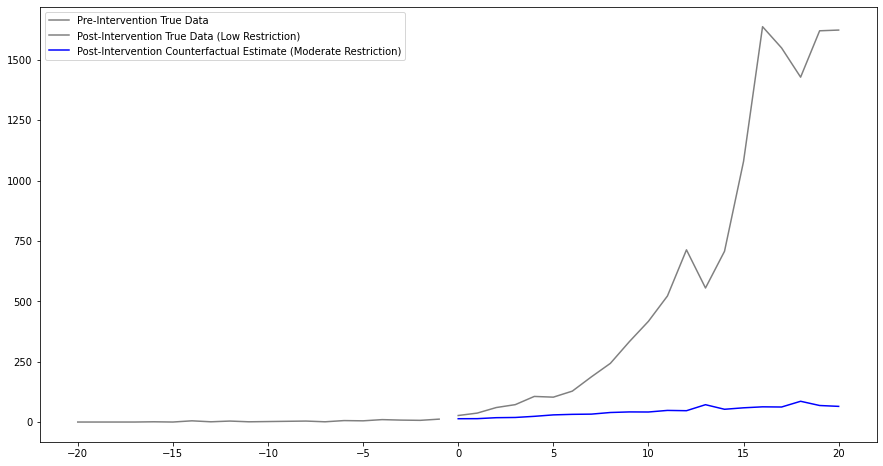

In [ ]:
plt.figure(figsize=(15, 8))

plt.plot(range(-20, 0), us_pre, 
         label="Pre-Intervention True Data", color='grey')

plt.plot(range(0, 21), us_post, 
         label="Post-Intervention True Data (Low Restriction)", color = 'grey')

plt.plot(range(0, 21), moderate_counterfactual_estimates, 
         label="Post-Intervention Counterfactual Estimate (Moderate Restriction)", color='blue')

plt.legend()

## Severe Mobility Restriction Counterfactual
We can use the code above to estimate what would have happened with a severe mobility reduction.

In [ ]:
# Step 1: Isolate the data of countries which did enact a severe mobility restriction
severe_countries_ts = covid_df[covid_df['country'].isin(severe_countries)]
severe_countries_ts.head()

t,country,-20.0,-19.0,-18.0,-17.0,-16.0,-15.0,-14.0,-13.0,-12.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0
0,Afghanistan,4.0,1.0,0.0,0.0,3.0,3.0,0.0,4.0,0.0,...,1.0,4.0,4.0,10.0,6.0,12.0,10.0,7.0,1.0,1.0
6,Argentina,1.0,0.0,0.0,2.0,2.0,1.0,4.0,5.0,1.0,...,11.0,5.0,13.0,11.0,9.0,7.0,5.0,10.0,7.0,4.0
8,Australia,5.0,5.0,5.0,5.0,1.0,3.0,3.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,Austria,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,31.0,29.0,17.0,22.0,23.0,17.0,12.0,21.0,13.0,16.0
13,Bangladesh,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,3.0,...,8.0,5.0,2.0,5.0,2.0,5.0,1.0,3.0,13.0,7.0


In [ ]:
## Step 2: Denoise the data
Y_pre = severe_countries_ts.loc[:, -20:-1].to_numpy()

u, s, vh = np.linalg.svd(Y_pre)
r_tilde = 3
smat = np.zeros((u.shape[0], vh.shape[0]))
smat[:r_tilde, :r_tilde] = np.diag(s[:r_tilde])

Y_pre_tilde = u @ smat @ vh

In [ ]:
# Step 3: Learn the pre-intervention model
import statsmodels.api as sm

dvs = us_pre
ivs = Y_pre_tilde.T
mod = sm.OLS(dvs, ivs)

res = mod.fit()

In [ ]:
# Step 4: Estimate the post-intervention counterfactual
Y_post = severe_countries_ts.loc[:, 0:20].to_numpy()
severe_counterfactual_estimates = res.predict(Y_post.T)

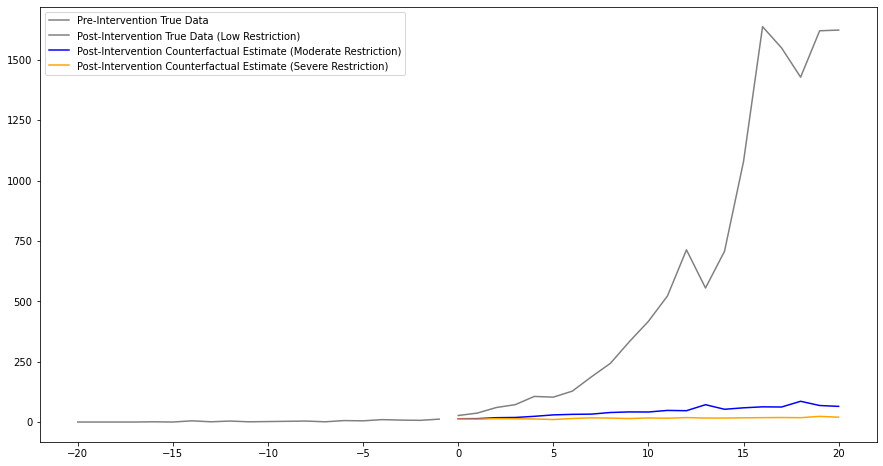

In [ ]:
plt.figure(figsize=(15, 8))

plt.plot(range(-20, 0), us_pre, 
         label="Pre-Intervention True Data", color='grey')

plt.plot(range(0, 21), us_post, 
         label="Post-Intervention True Data (Low Restriction)", color='grey')

plt.plot(range(0, 21), moderate_counterfactual_estimates, 
         label="Post-Intervention Counterfactual Estimate (Moderate Restriction)", color='blue')


plt.plot(range(0, 21), severe_counterfactual_estimates, 
         label="Post-Intervention Counterfactual Estimate (Severe Restriction)", color='orange')

plt.legend()

In [ ]:
# To get a summary of what the differences are, we can sum over the daily values in the post-intervention period
print(f'True Cumulative Fatalities:\t\t\t\t\t{sum(us_post)}')
print(f'Estimated Cumulative Fatalities (Moderate Intervention):\t  {sum(moderate_counterfactual_estimates)}')
print(f'Estimated Cumulative Fatalities (Severe Intervention):\t\t  {sum(severe_counterfactual_estimates)}')

True Cumulative Fatalities:					13146.0
Estimated Cumulative Fatalities (Moderate Intervention):	  928.0727623908249
Estimated Cumulative Fatalities (Severe Intervention):		  337.1366691601662


## Comments, Conclusions, and Future Directions

   1. Data cleaning and processing is key to any analysis and will affect our overall conclusions
   2. Comparing all three time series (low, moderate, and severe) we find that the moderate counterfactual results in over an order of magnitude fewer deaths than the true low data, and the severe counterfactual has slightly less than an order of magnitude fewer deaths than the moderate counterfactual. This suggests that even a moderate intervention can have a significant impact.
   3. We have only provided point estimates, but it is possible to extend the algorithm to generate confidence intervals as well. Interested students can see https://arxiv.org/abs/2006.07691 for details, but the confidence interval computation is outside the scope of this recitation.

### A Note on Selecting $\tilde{r}$ for Synthetic Interventions

One reasonable way to select the number of singular values to use in Synthetic Interventions is to identify low rank structure in the data, to see how many singular values are required to explain most of the variation in the data. This procedure actually has two purposes:

1. The plot of singular values helps us to know if there is low rank structure to begin with, which justifies the use of the Synthetic Interventions Method
2. Identifying the "elbow" point in the plot helps us to determine what a good value of $\tilde{r}$ should be.

Specifically, we want to check if the data in the pre-intervention period (where we assume all countries' time series obey a similar latent structure) is low rank.

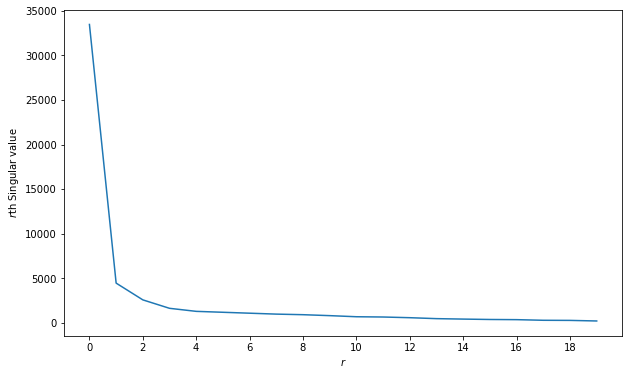

In [ ]:
u, s, vh = np.linalg.svd(covid_df.dropna().loc[:, -20:-1].to_numpy())
plt.figure(figsize=(10, 6))
plt.plot(np.power(s, 2))
#plt.semilogy()
plt.xlabel("$r$")
plt.ylabel("$r$th Singular value")
plt.xticks(np.arange(0, 20, 2))
plt.show()

The plot makes it clear that the dataset has a low rank structure (note that the plot is in log-scale, so a huge amount of variation is explained by the first few singular values compared to the last values). So, this helps us to justify the use of the synthetic interventions method.

From the plot above, there seems to be an elbow point around 3 or 4 -- either is justifiable in this case because the plot isn't completely clear between the two options.